In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats
import nibabel as nib

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

import scipy.stats as stats

In [2]:
# paths
local_path = '/project/data/ABCD/'
participants_tsv = local_path + 'participants_ABCD.tsv'
training_participants_tsv = local_path + 'train_participants_ABCD.tsv' 
testing_participants_tsv = local_path + 'test_participants_ABCD.tsv' 
selected_subject_path = local_path + 'training_output/selected_probs/'

likelihood_paths = [f"{local_path}training_output/get_likelihood_ABCD_{i}/" for i in range(9)]
likelihood_roi_paths = [f"{x}selected_probs/" for x in likelihood_paths]

nii_path = f"{local_path}training_output/"
nii_map_file = f"{nii_path}brain_map_transformer.nii.gz"
nii_atlas_file = f"{nii_path}AAL3v1_1mm.nii.gz"
info_atlas_file = f"{nii_path}AAL3v1_1mm.nii.txt"

In [17]:
df_atlas = pd.read_csv(info_atlas_file, usecols=[0,1], sep=' ', header=None, names = ['id', 'name'])

df_all = pd.read_csv(participants_tsv, sep='\t', header=0)
df_train = pd.read_csv(training_participants_tsv, sep='\t', header=0)
df_test = pd.read_csv(testing_participants_tsv, sep='\t', header=0)

for i, path in enumerate(likelihood_paths):   
    likelihood_npy = path + 'likelihood.npy'
    likelihood_tensors = np.load(likelihood_npy, allow_pickle=True)
    likelihood_values = list(map(lambda x: x.numpy()[0], likelihood_tensors))
    df_test[f"likelihood_{i}"] = likelihood_values

# fields_eval = ['participant_id','session_id','run_id', 'cbcl_scr_syn_anxdep_r','cbcl_scr_syn_withdep_r','cbcl_scr_syn_somatic_r', 
#                'cbcl_scr_syn_social_r','cbcl_scr_syn_thought_r','cbcl_scr_syn_attention_r',
#                'cbcl_scr_syn_rulebreak_r', 'cbcl_scr_syn_aggressive_r','cbcl_scr_syn_internal_r',
#                'cbcl_scr_syn_external_r','cbcl_scr_syn_totprob_r','cbcl_scr_dsm5_depress_r',
#                'cbcl_scr_dsm5_anxdisord_r','cbcl_scr_dsm5_somaticpr_r','cbcl_scr_dsm5_adhd_r',
#                'cbcl_scr_dsm5_opposit_r','cbcl_scr_dsm5_conduct_r']   
# df_test = pd.merge(df_test, df_all[fields_eval],
#                    on=['participant_id','session_id','run_id'],
#                    how='inner') #, suffixes=('_x2', '_y2')
# df_test.to_csv(testing_participants_tsv, sep="\t", index=False)

# #quantile used to split between low/high cbcl examples
# df_test['cbcl_bin'] = df_test['cbcl_scr_syn_totprob_r'] > 25

# df_train = pd.merge(df_train, df_all,
#                     on=['participant_id','session_id','run_id'],
#                     how='inner', suffixes=('_x2', '_y2'))

In [18]:
df_test.columns

Index(['participant_id', 'session_id', 'run_id', 'age', 'sex', 'dataset',
       'likelihood_0', 'likelihood_1', 'likelihood_2', 'likelihood_3',
       'likelihood_4', 'likelihood_5', 'likelihood_6', 'likelihood_7',
       'likelihood_8', 'cbcl_scr_syn_anxdep_r', 'cbcl_scr_syn_withdep_r',
       'cbcl_scr_syn_somatic_r', 'cbcl_scr_syn_social_r',
       'cbcl_scr_syn_thought_r', 'cbcl_scr_syn_attention_r',
       'cbcl_scr_syn_rulebreak_r', 'cbcl_scr_syn_aggressive_r',
       'cbcl_scr_syn_internal_r', 'cbcl_scr_syn_external_r',
       'cbcl_scr_syn_totprob_r', 'cbcl_scr_dsm5_depress_r',
       'cbcl_scr_dsm5_anxdisord_r', 'cbcl_scr_dsm5_somaticpr_r',
       'cbcl_scr_dsm5_adhd_r', 'cbcl_scr_dsm5_opposit_r',
       'cbcl_scr_dsm5_conduct_r'],
      dtype='object')

In [9]:
df_train['age_x2'].describe()

count    6756.000000
mean        9.919269
std         0.621354
min         8.916667
25%         9.333333
50%         9.916667
75%        10.416667
max        11.000000
Name: age_x2, dtype: float64

In [4]:
print('Assessing Pearson-r (cbcl_total x td_likelihood)...\n')
for i in range(9):
    x = df_test['cbcl_scr_syn_totprob_r']
    y = df_test[f'likelihood_{i}']
    r, pval = stats.pearsonr(x, y)
    print(f'-- Transformer {i}:')
    print(f'r: {r}')
    print(f'pval: {pval}\n')

Assessing Pearson-r (cbcl_total x td_likelihood)...

-- Transformer 0:
r: 0.022832573124630492
pval: 0.17538174621765296

-- Transformer 1:
r: 0.023079276937239396
pval: 0.17076240976377202

-- Transformer 2:
r: 0.02222466351154757
pval: 0.18716110339614614

-- Transformer 3:
r: 0.023550743075830088
pval: 0.16218893057812978

-- Transformer 4:
r: 0.02442760976512724
pval: 0.14711287388402083

-- Transformer 5:
r: 0.02695757375101386
pval: 0.10959564498046735

-- Transformer 6:
r: 0.02312247046922884
pval: 0.16996310247007126

-- Transformer 7:
r: 0.02440501397912595
pval: 0.1474874314030222

-- Transformer 8:
r: 0.02434817612477989
pval: 0.1484328215284523



In [21]:
quant_low = np.quantile(df_test['cbcl_scr_syn_totprob_r'].values, 0.25)
quant_high = np.quantile(df_test['cbcl_scr_syn_totprob_r'].values, 0.75)
cols_likelihood = [f"likelihood_{i}" for i in range(9)]
cond_low = df_test['cbcl_scr_syn_totprob_r'] < quant_low
cond_high = df_test['cbcl_scr_syn_totprob_r'] > quant_high
low_cbcl_mean_likelihoods = df_test[cond_low][cols_likelihood].mean(axis=1).mean()
high_cbcl_mean_likelihoods = df_test[cond_high][cols_likelihood].mean(axis=1).mean()
print(f"Low cbcl mean likelihoods: {low_cbcl_mean_likelihoods} (n={len(df_test[cond_low])})")
print(f"High cbcl mean likelihoods: {high_cbcl_mean_likelihoods} (n={len(df_test[cond_high])})")

# normalize likelihods
df_test['likelihood_norm'] = (df_test[cols_likelihood].mean(axis=1) - \
                                   df_test[cols_likelihood].mean(axis=1).min()) / \
                             (df_test[cols_likelihood].mean(axis=1).max() - \
                                   df_test[cols_likelihood].mean(axis=1).min())
norm_low_cbcl_mean_likelihoods = df_test[cond_low]['likelihood_norm'].mean()
norm_high_cbcl_mean_likelihoods = df_test[cond_high]['likelihood_norm'].mean()
print(f"\nNormalized low cbcl mean likelihoods: {norm_low_cbcl_mean_likelihoods} (n={len(df_test[cond_low])})")
print(f"Normalized high cbcl mean likelihoods: {norm_high_cbcl_mean_likelihoods} (n={len(df_test[cond_high])})")

Low cbcl mean likelihoods: -12344.0830078125 (n=835)
High cbcl mean likelihoods: -12314.2666015625 (n=871)

Normalized low cbcl mean likelihoods: 0.8900302648544312 (n=835)
Normalized high cbcl mean likelihoods: 0.8919488787651062 (n=871)


In [43]:

# df_test[cond_low]['likelihood_norm'].sort_values()
df_test[df_test['participant_id'] == 'sub-NDARINVA3G711KJ'][cols_likelihood].mean().mean()


-26175.281

(array([  2.,   3.,   3.,  24.,  91., 205., 283., 191.,  61.,   8.]),
 array([0.70657784, 0.73587483, 0.7651718 , 0.79446876, 0.82376575,
        0.85306275, 0.88235974, 0.91165674, 0.9409537 , 0.97025067,
        0.99954766], dtype=float32),
 <BarContainer object of 10 artists>)

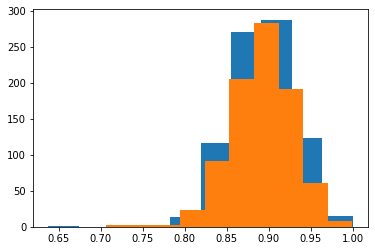

In [48]:
cond_subj = df_test['participant_id'] != 'sub-NDARINVA3G711KJ'
plt.hist(df_test[cond_low & cond_subj]['likelihood_norm'])
plt.hist(df_test[cond_high]['likelihood_norm'])


In [42]:
### 1 tail t-test does not apply

# #1
# # H0: mi = -12344.08203125
# # Ha: mi <> -12344.08203125

# #2
# valor_H0 = -12344.08203125
# n = len(df_test[cond_high])
# S = df_test[cond_high][cols_likelihood].mean(axis=1).std()
# X_barra = high_cbcl_mean_likelihoods

# #3
# t_obs = (X_barra - valor_H0) / (S / np.sqrt(n))

# #4
# g_l = n-1

# #5
# alpha = 0.05

# #6
# # p_valor = 2* p(t <= -abs(t_obs))
# p_valor = 2 * (1 - t.cdf(x=t_obs, df=g_l))
# p_valor



0.1274276554863638

In [22]:
print(df_test[cond_low]['likelihood_norm'].describe())
print(df_test[cond_high]['likelihood_norm'].describe())

count    835.000000
mean       0.890030
std        0.048673
min        0.000000
25%        0.867222
50%        0.892388
75%        0.916797
max        1.000000
Name: likelihood_norm, dtype: float64
count    871.000000
mean       0.891949
std        0.037111
min        0.706578
25%        0.868922
50%        0.893668
75%        0.916731
max        0.999548
Name: likelihood_norm, dtype: float64


In [23]:
#1
# H0: 2 population means are equal
# Ha: 2 population means are different

group_1 = (df_test[cond_low]['likelihood_norm'])

group_2 = (df_test[cond_high]['likelihood_norm'])

# perform two sample t-test with equal variances
stats.ttest_ind(a=group_1, b=group_2, equal_var=True)

Ttest_indResult(statistic=-0.917872286622448, pvalue=0.3588156274225852)

In [35]:
# # adjust distributions
# low_cbcl_test = df_test['cbcl_scr_syn_totprob_r'] <= 25
# high_cbcl_test = df_test['cbcl_scr_syn_totprob_r'] > 25
# df_low_cbcl_test = df_test[low_cbcl_test]
# df_high_cbcl_test = df_test[high_cbcl_test]
# df_high_cbcl_test_sample = df_high_cbcl_test.sample(frac=0.2, random_state=2)

# df_test_ok = pd.concat([df_low_cbcl_test,df_high_cbcl_test_sample])

# df_test = df_test_ok
# df_test['cbcl_bin'] = df_test['cbcl_scr_syn_totprob_r'] > 25 #cbcl quantile for first 75% examples

In [6]:
print('Men percentage train:', np.sum(df_train['sex_x2']=='M')/len(df_train))
print('Men percentage test:', np.sum(df_test['sex_x2']=='M')/len(df_test))

Men percentage train: 0.4942273534635879
Men percentage test: 0.5751986379114642


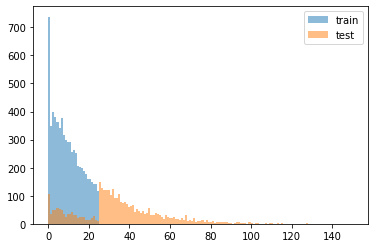

In [8]:
plt.figure(91)
bins = np.linspace(0,150,150)
dist_train = df_train['cbcl_scr_syn_totprob_r']
dist_test = df_test['cbcl_scr_syn_totprob_r']

plt.hist(dist_train, bins, #density=True, 
         alpha=0.5, label='train')
plt.hist(dist_test, bins, #density=True,
         alpha=0.5, label='test')
plt.legend(loc='upper right')
plt.show()

In [78]:
# x = df_test['cbcl_scr_syn_totprob_r']
# y = df_test['cbcl_scr_dsm5_conduct_t']
# print(stats.pearsonr(x, y))

(0.6623105757676903, 0.0)


In [31]:
# scaled_features = all_subjects_probs_mean

# kmeans_kwargs = {
#     "init": "random",
#     "n_init": 8,
#     "max_iter": 300,
#     "random_state": 42,}

# # A list holds the SSE values for each k
# sse = []
# for k in range(1, 20):
#     kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
#     kmeans.fit(scaled_features)
#     sse.append(kmeans.inertia_)

# plt.style.use("fivethirtyeight")
# plt.plot(range(1, 20), sse)
# plt.xticks(range(1, 20))
# plt.xlabel("Number of Clusters")
# plt.ylabel("SSE")
# plt.show()

# kmeans = KMeans(n_clusters=5, **kmeans_kwargs)
# kmeans.fit(scaled_features)
# df_test['kmeans_bin']=kmeans.labels_
# df_test.groupby(['kmeans_bin'])['kmeans_bin'].count()

In [30]:
# print(f"##### Showing the correlation of mean probabilities from transformer models #####\n")
# # map_idx = nib.load(nii_map_file)
# # map_idx_np = map_idx.get_fdata().astype(int)
# # map_idx_affine = map_idx.affine
# all_subjects_probs_mean = all_subjects_probs_sum / (model_num + 1)
# for clus_num in range(5):
#     print(f"##### Cluster number {clus_num} #####")
#     cluster_rows = (kmeans.labels_ == clus_num)
#     print(f"  Number of subjects: {sum(cluster_rows)}\n")
#     selected_subjects_probs_mean = all_subjects_probs_mean[cluster_rows]
#     selected_df_test = df_test[cluster_rows]
#     for field in fields_eval:
#         x = selected_df_test[field].values
#         r_list, pval_list, cor_idx_list = [], [], []
#         for col in range(selected_subjects_probs_mean.shape[1]):
#             y = selected_subjects_probs_mean[:,col]
#             r, pval = stats.pearsonr(x, y)
#             r_list.append(r)
#             pval_list.append(pval)
#         for i in range(len(r_list)):
#             if pval_list[i] < (0.01/16128): # p-value corretion for <0.01
#                 cor_idx_list.append(i)
#                 print(f"Field: {field} - Index:{i} r={r_list[i]} pval={pval_list[i]}")
#     #     if len(cor_idx_list) > 0:
#     #         cor_mask_np = np.isin(map_idx_np, cor_idx_list) * 1.0
#     #         cor_nii = nib.Nifti1Image(cor_mask_np, affine=map_idx_affine)
#     #         output_file = f"{nii_path}brain_mask_{field}.nii.gz"
#     #         print(f"Writing file {output_file}...\n")
#     #         nib.save(cor_nii, output_file)

In [34]:
(df_test['diag_any'] > 0).sum()

1024

In [33]:
atlas_id = 63
# bool mask for atlas id
mask_id = (atlas_idx_np == atlas_id)
# get corresponding 3d indices from map
indexes_3d = (mask_id * map_idx_np).nonzero()
# get corresponding index for serialized tokens
indexes_tokens = map_idx_np[indexes_3d]
# get mean probability from the atlasid indexes of tokens 
mean_probs_atlasid = all_subjects_probs_mean[:,indexes_tokens].mean(axis=1)

x = (df_test['diag_any'] > 0)
y = mean_probs_atlasid
# y = np.random.rand(737)
roc_auc_score(x,y)

0.54259140625

In [18]:
fields_eval = ['cbcl_scr_syn_anxdep_r','cbcl_scr_syn_withdep_r','cbcl_scr_syn_somatic_r', 
               'cbcl_scr_syn_social_r','cbcl_scr_syn_thought_r','cbcl_scr_syn_attention_r',
               'cbcl_scr_syn_rulebreak_r', 'cbcl_scr_syn_aggressive_r','cbcl_scr_syn_internal_r',
               'cbcl_scr_syn_external_r','cbcl_scr_syn_totprob_r','cbcl_scr_dsm5_depress_r',
               'cbcl_scr_dsm5_anxdisord_r','cbcl_scr_dsm5_somaticpr_r','cbcl_scr_dsm5_adhd_r',
               'cbcl_scr_dsm5_opposit_r','cbcl_scr_dsm5_conduct_r']

# load map and atlas
map_idx = nib.load(nii_map_file)
map_idx_np = map_idx.get_fdata().astype(int)
map_idx_affine = map_idx.affine
atlas_idx = nib.load(nii_atlas_file)
atlas_idx_np = atlas_idx.get_fdata().astype(int)
atlas_idx_affine = atlas_idx.affine

# store the mean likelihoods of all transformers in all_subjects_probs_mean
for model_num, path in enumerate(likelihood_roi_paths):
    print(f"--- Analyzing model {model_num} - {path}:")
    for i in range(len(df_test)):
        if i%1000 == 0:
            print(f"Processing row {i}...")
        selected_subject_npy = f"{path}ord_selected_probs_{i}.npy"
        subject_probs = np.load(selected_subject_npy, allow_pickle=True)
        if i == 0:
            all_subjects_probs = subject_probs
        else:
            all_subjects_probs = np.concatenate((all_subjects_probs,subject_probs),axis=0)
    
    if model_num == 0:
        all_subjects_probs_sum = all_subjects_probs
    else:
        all_subjects_probs_sum += all_subjects_probs
all_subjects_probs_mean = all_subjects_probs_sum / (model_num + 1)
print(f"\n")

# test each region (atlas_id) of brain for correlation
print("cbcl_group,atlas_id,atlas_descr,r-pearson,p-value")
for atlas_id in set(atlas_idx_np.flatten()):
    # does not evaluate background due to memory overflow
    if atlas_id != 0:
        # bool mask for atlas id
        mask_id = (atlas_idx_np == atlas_id)
        # get corresponding 3d indices from map
        indexes_3d = (mask_id * map_idx_np).nonzero()
        # get corresponding index for serialized tokens
        indexes_tokens = map_idx_np[indexes_3d]
        # get mean probability from the atlasid indexes of tokens 
        mean_probs_atlasid = all_subjects_probs_mean[:,indexes_tokens].mean(axis=1)
        # test correlation for each evaluation field
        for field in fields_eval:
            x = df_test[field].values
            y = mean_probs_atlasid
            r, pval = stats.pearsonr(x, y)
            if pval < (0.05/(170*17)): # p-value corretion for <0.05
                atlas_descr = df_atlas[df_atlas['id']==atlas_id]['name'].values[0]
                print(f"{field},{atlas_id},{atlas_descr},{r},{pval}")

--- Analyzing model 0 - /project/data/ABCD/training_output/get_likelihood_ABCD_0/selected_probs/:
Processing row 0...
Processing row 1000...
Processing row 2000...
Processing row 3000...
--- Analyzing model 1 - /project/data/ABCD/training_output/get_likelihood_ABCD_1/selected_probs/:
Processing row 0...
Processing row 1000...
Processing row 2000...
Processing row 3000...
--- Analyzing model 2 - /project/data/ABCD/training_output/get_likelihood_ABCD_2/selected_probs/:
Processing row 0...
Processing row 1000...
Processing row 2000...
Processing row 3000...
--- Analyzing model 3 - /project/data/ABCD/training_output/get_likelihood_ABCD_3/selected_probs/:
Processing row 0...
Processing row 1000...
Processing row 2000...
Processing row 3000...
--- Analyzing model 4 - /project/data/ABCD/training_output/get_likelihood_ABCD_4/selected_probs/:
Processing row 0...
Processing row 1000...
Processing row 2000...
Processing row 3000...
--- Analyzing model 5 - /project/data/ABCD/training_output/get_li

In [49]:
fields_eval = ['cbcl_scr_syn_anxdep_r','cbcl_scr_syn_withdep_r',
    'cbcl_scr_syn_somatic_r', 'cbcl_scr_syn_social_r',
    'cbcl_scr_syn_thought_r','cbcl_scr_syn_attention_r',
    'cbcl_scr_syn_rulebreak_r', 'cbcl_scr_syn_aggressive_r','cbcl_scr_syn_internal_r',
    'cbcl_scr_syn_external_r','cbcl_scr_syn_totprob_r',
    'cbcl_scr_dsm5_depress_r','cbcl_scr_dsm5_anxdisord_r',
    'cbcl_scr_dsm5_somaticpr_r','cbcl_scr_dsm5_adhd_r',
    'cbcl_scr_dsm5_opposit_r','cbcl_scr_dsm5_conduct_r']

for model_num, path in enumerate(likelihood_roi_paths):
    print(f"--- Analyzing model {model_num} - {path}:")
    for i in range(len(df_test)):
        if i%750 == 0:
            print(f"Processing row {i}...")
        selected_subject_npy = f"{path}ord_selected_probs_{i}.npy"
        subject_probs = np.load(selected_subject_npy, allow_pickle=True)
        if i == 0:
            all_subjects_probs = subject_probs
        else:
            all_subjects_probs = np.concatenate((all_subjects_probs,subject_probs),axis=0)
    
    if model_num == 0:
        all_subjects_probs_sum = all_subjects_probs
    else:
        all_subjects_probs_sum += all_subjects_probs
    print('\n')    
    for field in fields_eval:
        x = df_test[field].values
        r_list, pval_list = [], []
        for col in range(all_subjects_probs.shape[1]):
            y = all_subjects_probs[:,col]
            r, pval = stats.pearsonr(x, y)
            r_list.append(r)
            pval_list.append(pval)
        for i in range(len(r_list)):
            if pval_list[i] < (0.05/(16128*17)): # p-value corretion for <0.01
                print(f"Field: {field} - Index:{i} r={r_list[i]} pval={pval_list[i]}")
    print('\n')

print(f"##### Showing the correlation of mean probabilities from transformer models #####\n")
map_idx = nib.load(nii_map_file)
map_idx_np = map_idx.get_fdata().astype(int)
map_idx_affine = map_idx.affine
all_subjects_probs_mean = all_subjects_probs_sum / (model_num + 1)
for field in fields_eval:
    x = df_test[field].values
    r_list, pval_list, cor_idx_list = [], [], []
    for col in range(all_subjects_probs_mean.shape[1]):
        y = all_subjects_probs_mean[:,col]
        r, pval = stats.pearsonr(x, y)
        r_list.append(r)
        pval_list.append(pval)
    for i in range(len(r_list)):
        if pval_list[i] < (0.05/(16128*17)): # p-value corretion for <0.05
            cor_idx_list.append(i)
            print(f"Field: {field} - Index:{i} r={r_list[i]} pval={pval_list[i]}")
    if len(cor_idx_list) > 0:
        cor_mask_np = np.isin(map_idx_np, cor_idx_list) * 1.0
        cor_nii = nib.Nifti1Image(cor_mask_np, affine=map_idx_affine)
        output_file = f"{nii_path}brain_mask_{field}.nii.gz"
        print(f"Writing file {output_file}...\n")
        nib.save(cor_nii, output_file)

--- Analyzing model 0 - /project/data/ABCD/training_output/get_likelihood_ABCD_0/selected_probs/:
Processing row 0...
Processing row 750...
Processing row 1500...
Processing row 2250...
Processing row 3000...


Field: cbcl_scr_syn_social_r - Index:47 r=-0.08801560843040675 pval=1.6659974755853104e-07
Field: cbcl_scr_syn_social_r - Index:1336 r=-0.09201066848558984 pval=4.456686449758995e-08
Field: cbcl_scr_syn_social_r - Index:1339 r=-0.08992492515311316 pval=8.933453690691936e-08
Field: cbcl_scr_syn_social_r - Index:1345 r=-0.0902540686864955 pval=8.01311183819372e-08
Field: cbcl_scr_syn_social_r - Index:1368 r=-0.09032152683081535 pval=7.83616264515671e-08
Field: cbcl_scr_syn_rulebreak_r - Index:23 r=-0.09734700191552191 pval=7.015845420602217e-09
Field: cbcl_scr_syn_rulebreak_r - Index:47 r=-0.10384176582888484 pval=6.454493358366994e-10
Field: cbcl_scr_syn_rulebreak_r - Index:1327 r=-0.0878746359849432 pval=1.7435651826031784e-07
Field: cbcl_scr_syn_rulebreak_r - Index:1336 r=-0.09

/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Field: cbcl_scr_syn_social_r - Index:7 r=-0.09096186719239445 pval=6.334365053193504e-08
Field: cbcl_scr_syn_social_r - Index:10 r=-0.09094725719157284 pval=6.365290943267283e-08
Field: cbcl_scr_syn_social_r - Index:44 r=-0.08911254500312596 pval=1.1664224134764861e-07
Field: cbcl_scr_syn_social_r - Index:95 r=-0.09204736068594167 pval=4.401896494734669e-08
Field: cbcl_scr_syn_social_r - Index:96 r=-0.09146898363288061 pval=5.346669982040131e-08
Field: cbcl_scr_syn_social_r - Index:104 r=-0.08785949665525451 pval=1.7520999396023932e-07
Field: cbcl_scr_syn_social_r - Index:698 r=0.1082464079793568 pval=1.1750541089645752e-10
Field: cbcl_scr_syn_social_r - Index:699 r=0.10220608221639756 pval=1.1938575383874452e-09
Field: cbcl_scr_syn_social_r - Index:700 r=0.08844500014293506 pval=1.4497364730874494e-07
Field: cbcl_scr_syn_social_r - Index:1346 r=0.08918355902648763 pval=1.1396463114681135e-07
Field: cbcl_scr_syn_social_r - Index:3385 r=0.09053988256088322 pval=7.288953155261355e-08
Fie

In [61]:
print('Low cbcl:',df[df['cbcl_bin']==0]['likelihood'].mean())
print('High cbcl:',df[df['cbcl_bin']==1]['likelihood'].mean())

Low cbcl: -11115.577
High cbcl: -11112.922


In [66]:
df.columns.to_list()

['participant_id',
 'session_id',
 'run_id',
 'age_x2',
 'sex_x2',
 'dataset_x2',
 'likelihood',
 'collection_id_x',
 'abcd_cbcls01_id',
 'dataset_id_x',
 'subjectkey',
 'src_subject_id_x',
 'interview_date_x',
 'interview_age_x',
 'sex_x',
 'eventname_x',
 'cbcl_scr_syn_anxdep_r',
 'cbcl_scr_syn_anxdep_t',
 'cbcl_scr_syn_anxdep_m',
 'cbcl_scr_syn_anxdep_nm',
 'cbcl_scr_syn_withdep_r',
 'cbcl_scr_syn_withdep_t',
 'cbcl_scr_syn_withdep_m',
 'cbcl_scr_syn_withdep_nm',
 'cbcl_scr_syn_somatic_r',
 'cbcl_scr_syn_somatic_t',
 'cbcl_scr_syn_somatic_m',
 'cbcl_scr_syn_somatic_nm',
 'cbcl_scr_syn_social_r',
 'cbcl_scr_syn_social_t',
 'cbcl_scr_syn_social_m',
 'cbcl_scr_syn_social_nm',
 'cbcl_scr_syn_thought_r',
 'cbcl_scr_syn_thought_t',
 'cbcl_scr_syn_thought_m',
 'cbcl_scr_syn_thought_nm',
 'cbcl_scr_syn_attention_r',
 'cbcl_scr_syn_attention_t',
 'cbcl_scr_syn_attention_m',
 'cbcl_scr_syn_attention_nm',
 'cbcl_scr_syn_rulebreak_r',
 'cbcl_scr_syn_rulebreak_t',
 'cbcl_scr_syn_rulebreak_m',
 '

In [77]:
x = df[df['cbcl_bin']==1]['cbcl_scr_syn_totprob_t']
y = df[df['cbcl_bin']==1]['likelihood']
r, pval = stats.pearsonr(x, y)
print('r:', r)
print('pval:', pval)

r: 0.05350735516452503
pval: 0.005514191521147578


(array([1306.,  594.,  362.,  211.,  103.,   59.,   28.,   16.,    5.,
           5.]),
 array([ 26. ,  37.3,  48.6,  59.9,  71.2,  82.5,  93.8, 105.1, 116.4,
        127.7, 139. ]),
 <BarContainer object of 10 artists>)

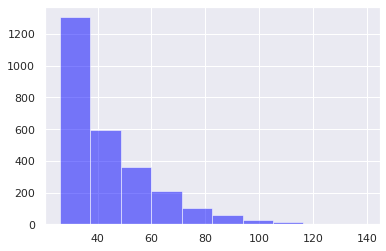

In [52]:
# hist1 = df[df['cbcl_bin']==0]['cbcl_scr_syn_totprob_r']
# hist2 = df[df['cbcl_bin']==1]['cbcl_scr_syn_totprob_r']
dist1 = df[df['cbcl_bin']==0]['likelihood']
# dist2 = df[df['cbcl_bin']==1]['likelihood']
dist2 = df[df['cbcl_bin']==1]['cbcl_scr_syn_totprob_r']

fig, ax = plt.subplots()
# ax.hist(dist1, color='green', alpha=0.5)
ax.hist(dist2, color='blue', alpha=0.5)

In [44]:
# print to screen and file at same time
def dual_print(f, *args, **kwargs): 
    print(*args, **kwargs) 
    print(*args, **kwargs, file=f)

n(total)= 3524 r= -0.011
n(False)= 835 r(False)= -0.002
n(True)= 2689 r(True)= -0.015

writing /project/data/ABCD/training_output/scatterplot.png
writing /project/data/ABCD/training_output/boxplot.png



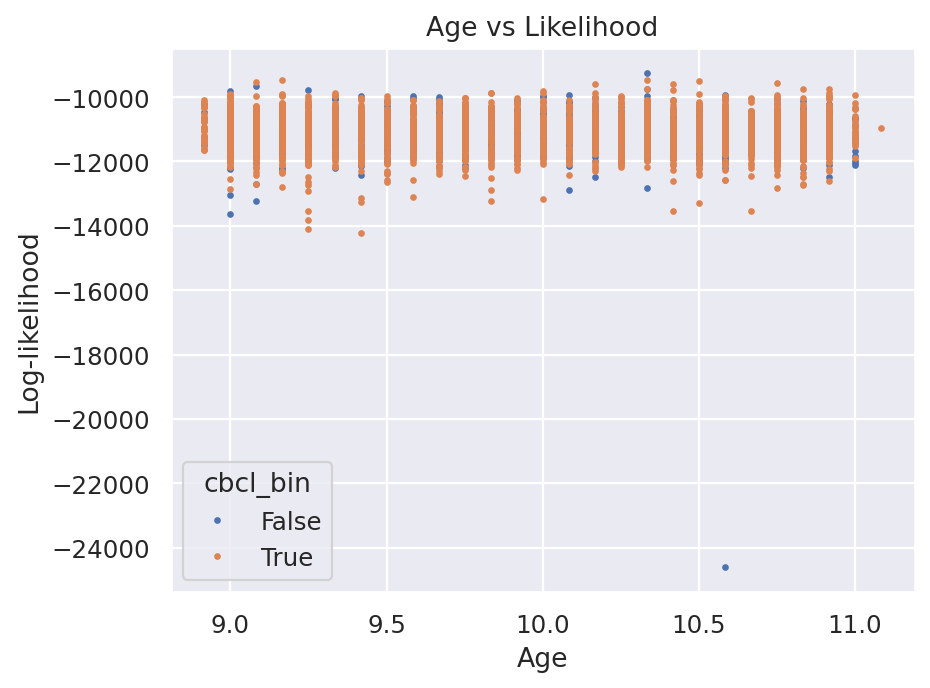

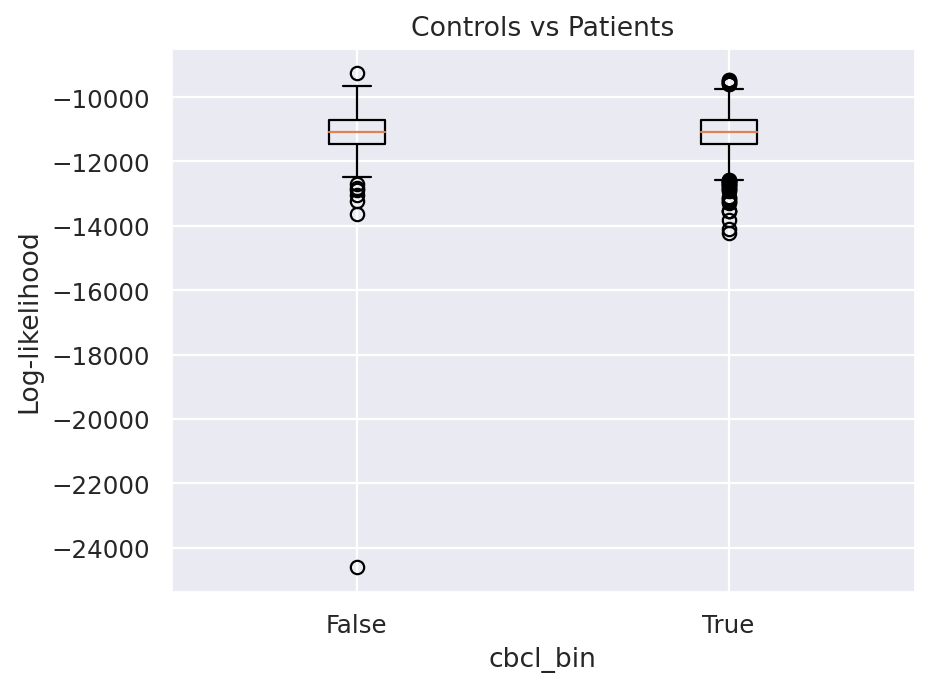

In [46]:
# make plots
sn.set_theme()
fig1, ax1 = plt.subplots(figsize=(6,4.5),dpi=160)
fig2, ax2 = plt.subplots(figsize=(6,4.5),dpi=160)

# print stats
f_out = open(local_path+'output.txt', 'w')
x = df['age_x2'].values
y = df['likelihood'].values
n = len(x)
r, _ = stats.pearsonr(x, y)
dual_print(f_out, 'n(total)=', n, 'r=', round(r,3))

# prepare data
boxp_data, boxp_names = [], []
for name, group in df.groupby('cbcl_bin'):
    x = group['age_x2'].values
    y = group['likelihood'].values
    n = len(group['age_x2'].values)
    r, _ = stats.pearsonr(x, y)
    boxp_data.append(y)
    boxp_names.append(name)
    dual_print(f_out, 'n('+str(name)+')=', n, 'r('+str(name)+')=', round(r,3))
    _ = ax1.plot(x, y, marker='.', linestyle='', markersize=4, label=name)

# scatter plot    
ax1.set_title('Age vs Likelihood')
ax1.set_ylabel('Log-likelihood')
ax1.set_xlabel('Age')    
ax1.legend(title='cbcl_bin')
ax1.grid(True)

# box plot
ax2.set_title('Controls vs Patients')
ax2.set_ylabel('Log-likelihood')
ax2.set_xlabel('cbcl_bin')
_ = ax2.boxplot(boxp_data)
_ = ax2.set_xticklabels(boxp_names)

# save png files
dual_print(f_out,'\nwriting ' + local_path + 'scatterplot.png')
fig1.savefig(local_path + 'scatterplot.png', bbox_inches='tight')
dual_print(f_out,'writing ' + local_path + 'boxplot.png\n')
fig2.savefig(local_path + 'boxplot.png', bbox_inches='tight')

f_out.close()